# Dimensionality reduction

The dataset has increased its variables considerably due to the new generated ones, feature engineering and node embeddings. In order to reduce its complexity and avoid overfitting, it is ideal to apply a dimensionality reduction technique.

Recursive Feature Extraction is a dimensionality reduction technique that evaluate the models with the best combination of features, in order to keep only those features that improve the model's performance. It can be applied with cross validation to avoid overfitting during the process. The chosen model to apply RFE is XGBoost Classifier since it can capture complex relationships on the data, very helpful to not discard features that have interaction with other ones.

## Preparing environment

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import sys
sys.path.append('../high_performance_employee_resign_prediction')
from utils import paths

## Importing data

In [2]:
train_df = pd.read_csv(paths.data_processed_dir('train_processed.csv'))
test_df = pd.read_csv(paths.data_processed_dir('test_processed.csv'))

train_red_df = pd.read_csv(paths.data_processed_dir('train_red_processed.csv'))
test_red_df = pd.read_csv(paths.data_processed_dir('test_red_processed.csv'))

In [3]:
# Extracting node embeddings to not affect them
embeddings_columns = [col for col in train_df.columns.tolist() if 'embedding' in col]

embeddings_train = train_df[embeddings_columns]
embeddings_test = test_df[embeddings_columns]

train_df = train_df.drop(columns=embeddings_columns)
test_df = test_df.drop(columns=embeddings_columns)
train_red_df = train_red_df.drop(columns=embeddings_columns)
test_red_df = test_red_df.drop(columns=embeddings_columns)

In [4]:
# Extracting ids and target features
ids = ['id_employee', 'id_last_boss']

ids_train = train_df[ids]
ids_test = test_df[ids]

y = train_df['resign']

train_df.drop(columns=ids, inplace=True)
train_df.drop(columns=['resign'], inplace=True)
train_red_df.drop(columns=ids, inplace=True)
train_red_df.drop(columns=['resign'], inplace=True)
test_df.drop(columns=ids, inplace=True)
test_red_df.drop(columns=ids, inplace=True)

## Applying RFE

In [5]:
# Initializing XGBoost Classifier
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')

# Initializing RFECV
rfecv = RFECV(
    estimator=xgb,
    step=1, # Number of features to remove at each iteration
    cv=5, # Using 5 folds to make cross validation
    scoring='f1',
    n_jobs=-1,
    verbose=2
    )

### Applying on full data

In [6]:
# Applying RFECV on full data

rfecv.fit(train_df, y)

print(f'Optimal number of features: {rfecv.n_features_}')

# List the selected features
selected_features = train_df.columns[rfecv.support_]
print("Selected Features: ", selected_features)

Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 fe

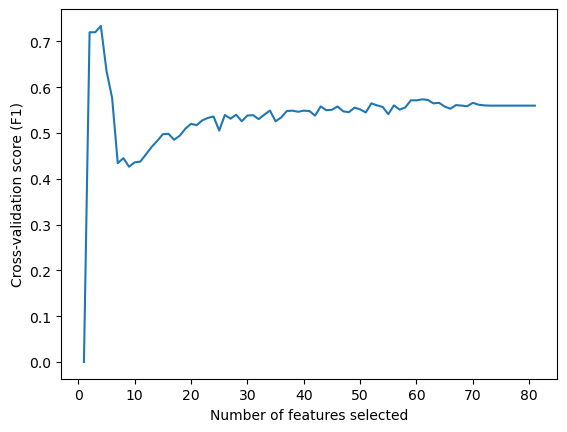

In [7]:
# Plot the cross-validation scores as the number of features changes
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (F1)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

In [21]:
train_df = pd.concat([ids_train, train_df[selected_features], embeddings_train, y], axis=1)
test_df = pd.concat([ids_test, test_df[selected_features], embeddings_test], axis=1)

In [22]:
# Saving reduced data

train_df.to_csv(paths.data_processed_dir('train_dimrdcd.csv'), index=False)
test_df.to_csv(paths.data_processed_dir('test_dimrdcd.csv'), index=False)